In [4]:
import os
import torch
from torchvision import models, transforms, datasets
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
def list_images_in_path(path, recursive=True, extensions=('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp', '.tiff')):
    """
    Lista todas las imágenes en una carpeta dada.

    Parámetros:
    - path: ruta principal a explorar.
    - recursive: si True, busca también en subdirectorios.
    - extensions: tupla de extensiones válidas.

    Retorna:
    - Lista de rutas absolutas de imágenes encontradas.
    """
    image_paths = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.lower().endswith(extensions):
                image_paths.append(os.path.join(root, file))
        if not recursive:
            break  # No seguir en subdirectorios
    return image_paths


In [6]:
def get_input_size(model_name):
    if model_name == 'inception_v3':
        return (299, 299)
    return (224, 224)

def get_model(model_name, num_classes):
    if model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(weights=None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'resnet50':
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError(f"Modelo '{model_name}' no soportado en este script.")
    return model

def predict(image_path, model_path, model_name, data_dir, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

    # Obtener clases
    dataset = datasets.ImageFolder(data_dir)
    class_names = dataset.classes
    num_classes = len(class_names)

    # Transformaciones
    input_size = get_input_size(model_name)
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # Preparar imagen
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Cargar modelo y pesos
    model = get_model(model_name, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Predicción
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)
        predicted_class = class_names[pred.item()]

    print(f"✅ Predicción: {predicted_class}")
    plt.imshow(image)
    plt.title(f"Predicción: {predicted_class}")
    plt.axis("off")
    plt.show()

    return predicted_class


In [11]:
imagenes_path = "/home/nahumfg/Projects/GithubProjects/TesisTransparenciaDataset/data/a_org/asistencia"
imagenes_asistencia = list_images_in_path(imagenes_path)

imagenes_path = "/home/nahumfg/Projects/GithubProjects/TesisTransparenciaDataset/data/a_org/votacion"
imagenes_votacion = list_images_in_path(imagenes_path)

print(len(imagenes_asistencia))
print(len(imagenes_votacion))

5918
7952


✅ Predicción: votacion


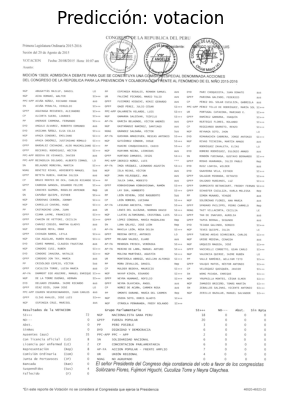

'votacion'

In [12]:
predict(
    image_path=imagenes_votacion[0],
    model_path="mobilenet_v2_best_parallel.pth",
    model_name="mobilenet_v2",
    data_dir="../../data/a_org", #! Para saber las etiquetas de las clases
    device='cuda'
)

✅ Predicción: otros


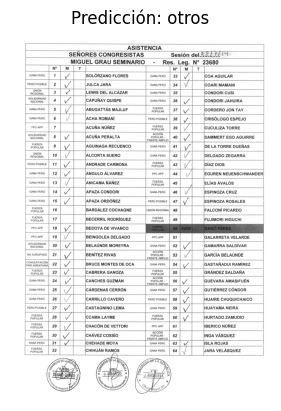

'otros'

In [14]:
predict(
    image_path=imagenes_asistencia[0],
    model_path="mobilenet_v2_best_parallel.pth",
    model_name="mobilenet_v2",
    data_dir="../../data/a_org", #! Para saber las etiquetas de las clases
    device='cuda'
)